# ECE 570 Assignment 6 Exercise






Your Name:

## Exercise 1: Creating an image denoiser using a CNN autoencoder. (30 points)
In this exercise you are trying to build a autoencoder with CNN layers that can denoise images. 

### Task 1: Create additive noise transform
1. Add code to `AddGaussianNoise` transform class that will:
  * Add additive Gaussian noise to the batch of input images (i.e add noise with gaussian distribution on each pixel). The noise for every pixel should have mean value 0 and standard deviation of 0.3, i.e $ \epsilon \sim N(0, 0.3)$.
  * Clip the values to be between 0 and 1 again as they may be outside the range for pixel values after adding Gaussian noise.
2. Plot the first 3 training images and their noisy counterparts in a 2x3 subplot with appropriate titles, figure size, label, etc.

In this task, we concatenate the original dataset and noisy dataset and get a single dataloader. You should be careful with what you load at each iteration. In a more general case, there are many ways of dealing with multiple datasets. For example, you can create separate dataloaders and use ``zip`` to load samples from them. Here is a post discussing how to use ``zip`` [https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1](https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1). 

In [84]:
# Import and load MNIST data
import torchvision
import torch
import matplotlib.pyplot as plt


class AddGaussianNoise(object):
  ###########################   <YOUR CODE>  ############################
  def __init__(self, mean=1, std=1):
    self.mean = mean
    self.std = std
      
  def __call__(self, tensor):
    tensor = tensor + (self.std**0.5)*torch.randn(tuple(tensor.shape)) + self.mean*torch.ones(tuple(tensor.shape))
    tensor = torch.clamp(tensor, min=0., max=1.)
    return tensor

  #########################  <END YOUR CODE>  ############################


transform_noisy = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), AddGaussianNoise(0.,0.3)])
transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_noisy = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_noisy)
train_dataset_original = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset_noisy = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_noisy)
test_dataset_original = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)

print(torch.max(train_dataset_noisy.__getitem__(0)[0]).item())
print(torch.min(train_dataset_noisy.__getitem__(0)[0]).item())

1.0
0.0


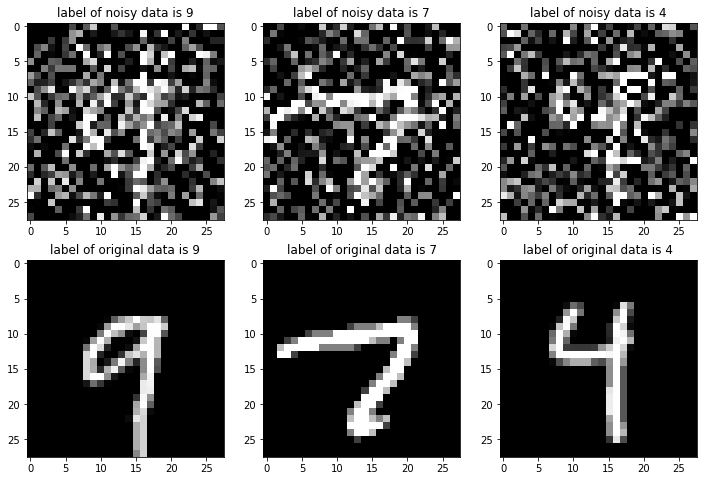

In [85]:
class ConcatDataset(torch.utils.data.Dataset):
  def __init__(self, *datasets):
    self.datasets = datasets

  def __getitem__(self, i):
    return tuple(d[i] for d in self.datasets)

  def __len__(self):
    return min(len(d) for d in self.datasets)


batch_size_train, batch_size_test = 200, 1000
train_loader = torch.utils.data.DataLoader(ConcatDataset(train_dataset_noisy, train_dataset_original),
                      batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ConcatDataset(test_dataset_noisy, test_dataset_original),
                      batch_size=batch_size_test, shuffle=False)

###########################   <YOUR CODE>  ############################
# Plot the first 3 training images with corresponding noisy images 
for item1,item2 in train_loader:
    image_batch1, labels1 = item1
    image_batch2, labels2 = item2
    # print(item1[0].shape)
    # print(item1[1].shape)
    # break
    fig,ax = plt.subplots(2,3)
    fig.set_size_inches(12,8)
    for idx in range(3):
      ax[0,idx].imshow(image_batch1[idx][0], cmap='gray')
      ax[0,idx].set_title(f'label of noisy data is {labels1[idx]}')
      ax[1,idx].imshow(image_batch2[idx][0], cmap='gray')
      ax[1,idx].set_title(f'label of original data is {labels2[idx]}')
    fig.show()
    break

#########################  <END YOUR CODE>  ############################

### Task 2: Create and train a denoising autoencoder
1. Build an autoencoder neural network structure with encoders and decoders that is a little more complicated than in the instructions. You can also create the network to have convolutional or transpose convolutional layers. (You can follow the instructions code skeleton with a key difference of using convolutional layers).
2. Move your model to GPU so that you can train your model with GPU. (This step can be simultaneously implemented in the above step)
3. Train your denoising autoencoder model with appropriate optimizer and **MSE** loss function. The loss function should be computed between the output of the noisy images and the clean images, i.e., $L(x, g(f(\tilde{x})))$, where $\tilde{x} = x + \epsilon$ is the noisy image and $\epsilon$ is the Gaussian niose. You should train your model with enough epochs so that your loss reaches a relatively steady value. **Note: Your loss on the test data should be lower than 20.** You may have to experiment with various model architectures to achieve this test loss.
4. Visualize your result with a 3 x 3 grid of subplots. You should show 3 test images, 3 test images with noise added, and 3 test images reconstructed after passing your noisy test images through the DAE.

Epoch 1: [60000/60000] Loss: 88.610185546875
Test result on epoch 1: Avg loss is 92.80822890625
Epoch 2: [60000/60000] Loss: 79.4549609375
Test result on epoch 2: Avg loss is 78.01551953125


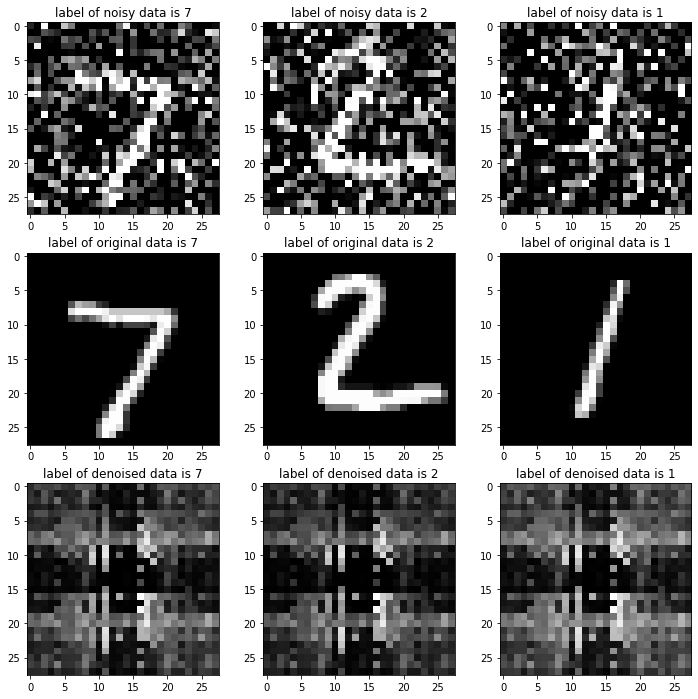

In [86]:
###########################   <YOUR CODE>  ############################
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

latent_feature = 16


class cnn_autoencoder(nn.Module):
    def __init__(self):
        super(cnn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1), 
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 8, 3, stride=2, padding=1), 
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2), 
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 1, 28, 28)
        return x

device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)

AE = cnn_autoencoder().to(device)
optimizer = optim.Adam(AE.parameters(), lr=1e-4)
loss_fn = nn.MSELoss(reduction='sum')

def train(epoch, device):

  AE.train() # we need to set the mode for our model

  for batch_idx, (item1,item2) in enumerate(train_loader): # Note that we do not need the labels
    image_batch1, _ = item1
    image_batch2, _ = item2

    optimizer.zero_grad()
    image_batch1 = image_batch1.to(device)
    image_batch2 = image_batch2.to(device)
    output = AE(image_batch1)
    loss = loss_fn(output, image_batch2) # Here is a typical loss function (Mean square error)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset)))
    if (batch_idx+1) % 300 == 0: # We visulize our output every 300 batches
      print(f'Epoch {epoch}: [{(batch_idx+1)*len(image_batch1)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


def test(epoch, device):

  AE.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for item1,item2 in test_loader:
      image_batch1, _ = item1
      image_batch2, _ = item2
      image_batch1 = image_batch1.to(device)
      image_batch2 = image_batch2.to(device)
      output = AE(image_batch1)
      test_loss += loss_fn(output, image_batch2).item()
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')
  return test_loss


train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 2

for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  test_loss = test(epoch, device=device)
  # if test_loss < 20:
  #   break

AE.eval()

with torch.no_grad():
    for item1,item2 in test_loader:
      image_batch1, labels1 = item1
      image_batch2, labels2 = item2
      image_batch1 = image_batch1.to(device)
      image_batch2 = image_batch2.to(device)
      output = AE(image_batch1)
      fig,ax = plt.subplots(3,3)
      fig.set_size_inches(12,12)
      for idx in range(3):
        ax[0,idx].imshow(image_batch1[idx][0].cpu().detach().numpy(), cmap='gray')
        ax[0,idx].set_title(f'label of noisy data is {labels1[idx]}')
        ax[1,idx].imshow(image_batch2[idx][0].cpu().detach().numpy(), cmap='gray')
        ax[1,idx].set_title(f'label of original data is {labels2[idx]}')
        ax[2,idx].imshow(output[idx][0].cpu().detach().numpy(), cmap='gray')
        ax[2,idx].set_title(f'label of denoised data is {labels1[idx]}')
      fig.show()
      break
#########################  <END YOUR CODE>  ############################

## Exercise 2: Build a variational autoencoder(VAE) that can generate MNIST images (70 points)

### Task 0: Setup
1. Import necessary packages
2. Load the MNIST data as above.
3. Specify the device.

In [87]:
###########################   <YOUR CODE>  ############################
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np

class AddGaussianNoise(object):

  def __init__(self, mean=1, std=1):
    self.mean = mean
    self.std = std
      
  def __call__(self, tensor):
    tensor = tensor + (self.std**0.5)*torch.randn(tuple(tensor.shape)) + self.mean*torch.ones(tuple(tensor.shape))
    tensor = torch.clamp(tensor, min=0., max=1.)
    return tensor

class ConcatDataset(torch.utils.data.Dataset):
  def __init__(self, *datasets):
    self.datasets = datasets

  def __getitem__(self, i):
    return tuple(d[i] for d in self.datasets)

  def __len__(self):
    return min(len(d) for d in self.datasets)

transform_noisy = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), AddGaussianNoise(0.,0.3)])
transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_noisy = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_noisy)
train_dataset_original = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset_noisy = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_noisy)
test_dataset_original = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)

batch_size_train, batch_size_test = 200, 1000
train_loader = torch.utils.data.DataLoader(ConcatDataset(train_dataset_noisy, train_dataset_original),
                      batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ConcatDataset(test_dataset_noisy, test_dataset_original),
                      batch_size=batch_size_test, shuffle=False)


#########################  <END YOUR CODE>  ############################

### Task 1: VAE Loss function
Construct your loss function. The loss function for VAE is a little bit difficult:
$$
\begin{aligned}
\textbf{NegativeELBO}(x, g, f) &= \mathbb{E}_{q_f}[-\log p_g(x|z)] + KL(q_f(z|x), p_g(z))\\
 &= \text{ReconstructionLoss} + \text{Regularizer}
\end{aligned}
$$
In this exercise, you will build the VAE (variational autoencoder) model satisfying following conditions which simplifies the computation of loss function:
1. $p_g(z)$ is a standard normal distribution.
2. $q_f(z|x)$ is a multivariate Gaussian with trainable mean and variance along each dimension.
3. The output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.

While we discussed the Gaussian distribution in class, here we assume the output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.
The value of the pixel corresponds to the average of the Bernoulli distribution.
This loss can be seen in Appendix C.1 of the original VAE paper: https://arxiv.org/pdf/1312.6114.pdf.
With such assumpition, the reconstruction loss can be calculated using the binary-cross-entropy loss between the original images and the output of the VAE.
See [torch.nn.functional.binary_cross_entropy](https://pytorch.org/docs/stable/nn.functional.html#binary-cross-entropy).
You should use the sum reduction of the loss to sum the loss over all the pixels. 

The second part is the KL-Divergence between your model's approximate posterier $q_f(z|x)$ and the model prior $p_g(z)$.
If we assume $p_g(z)$ is a standard normal distribution and $q_f(z|x)$ is a Gaussian with unknown mean and variance, then this KL divergence can be computed in closed form (see Appendix B of original VAE paper above):
$KL(q_f(z|x), p_g(z)) = -\frac{1}{2}\sum_{j=1}^d(1+\log(\sigma_j^2)-\mu_j^2-\sigma_j^2)$. 


Your task here is to write a function `vae_loss` that takes the value of your model's output, the original images, mu, and log_var (i.e., the $\log(\sigma_j^2)$ term), and returns the the reconstruction loss and the KL loss terms **separately** (i.e., the function should return two loss arrays). To visualize these losses separately in a later task, you will need the reconstruction loss and KL loss separated.


In [88]:
def vae_loss(output, mu, log_var, images):
  """
  :param output: this the output of your neural network
  :param mu: this is the mu from the latent space
  :param log_var: this is the log_var from the latent space
  :param images: this is the original sets of images
  """
  ###########################   <YOUR CODE>  ############################
  recon_loss = F.binary_cross_entropy(output, images, reduction='sum')
  # KL_loss    = -0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1)
  KL_loss    = torch.sum(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
  return recon_loss, KL_loss
  #########################  <END YOUR CODE>  ############################


### Task 2: VAE model
Build the VAE (variational autoencoder) model based on the instructions given below and in the comments.
* Inside the `reparameterize` function you job is to output a latent vector. You should first calculate the standard deviation `std` from the log variance variable `log_var` (i.e., compute $\sigma$ from $\log (\sigma^2)$, then generate the vector in Gaussian distribution with `mu` and `std`.  **Importantly**, this should use the reparametrization trick so that we can backpropagate through this random step.

* Inside the `forward` function you should extract the `mu` and `log_var` from the latent representation after the encoder. The output of encoder should be in the dimension ` [batch_size x 2 x latent_feature]`, which includes a mean and log variance for each latent feature and for each instance in the batch.  Remember that in VAEs, the encoder outputs the parameters of the latent distribution. Note that the second dimension has value 2, so you need to split this tensor into two components, one called `mu` and the other called `log_var`---which will be fed into reparameterize.



In [119]:
import torch.nn as nn
import torch.nn.functional as F


class our_VAE(nn.Module):
  def __init__(self, latent_feature = 16): # you can use any number of latent features you want in the training
    super(our_VAE, self).__init__()

    self.latent_feature = latent_feature

    ###########################   <YOUR CODE>  ############################
    # define the transformations for your encoder and decoder
    self.encode = nn.Sequential(
        nn.Conv2d(1, 16, 3, stride=3, padding=1), 
        nn.ReLU(True),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(16, 8, 3, stride=2, padding=1), 
        nn.ReLU(True),
        nn.MaxPool2d(2, stride=1),
        nn.Flatten()
    )
    self.decode = nn.Sequential(
        nn.Unflatten(1, (8,2,2)),
        nn.ConvTranspose2d(8, 16, 3, stride=2), 
        nn.ReLU(True),
        nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),
        nn.ReLU(True),
        nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),
        nn.Sigmoid()
    )
    self.fc1 = nn.Linear(32, self.latent_feature)
    self.fc2 = nn.Linear(32, self.latent_feature)
    self.fc3 = nn.Linear(self.latent_feature, 32)
    
    #########################  <END YOUR CODE>  ############################

  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the latent space
    :param log_var: the log variance from the latent space

    You should return a sample with gaussian distribution N(mu, var) using 
    the reparameterization trick.
    """
    ###########################   <YOUR CODE>  ############################
    std = torch.exp(log_var*0.5)
    eps = torch.randn_like(std)
    sample = mu + (eps * std) 
    #########################  <END YOUR CODE>  ############################
    return sample
  def encoder(self, x):
    """
    :param x: input distribution

    You should first compute the parameters mu and log_var for Gaussian distribution q(z|x), and 
    then get samples from q(z|x) using the reparameterize function you just created.
    The final output should include mu, log_var and z~q(z|x)
    """
    ###########################   <YOUR CODE>  ############################
    h = self.encode(x)
    mu, log_var = self.fc1(h), self.fc2(h)
    z = self.reparameterize(mu, log_var)
    #########################  <END YOUR CODE>  ###########################

    return mu, log_var, z

  def decoder(self, z):
    """
    :param z: latent distribution

    You should compute the output x given latent samples z
    """

    ###########################   <YOUR CODE>  ############################
    x = self.fc3(z)
    x = self.decode(x)
    #########################  <END YOUR CODE>  ###########################
    return x
  
  def forward(self, x):
    """
    :param x: input variables

    You should compute the output images using the encoder and decoder you just defined.
    Remember to return the mu and log_var for the computation of loss.
    """

    ###########################   <YOUR CODE>  ############################
    z, mu, log_var = self.encoder(x)
    z = self.decoder(z)
    #########################  <END YOUR CODE>  ###########################

    return z, mu, log_var

### Task 3: Train and visualize output
1. Train your model with an appropriate optimizer and the above loss function. You should train your model with enough epochs so that your loss reaches a relatively steady value.

2. Visualize your result. You should **show three pairs of images** where each pair consists of an original test image and its VAE reconstructed version.

3. Keep track of the loss. You should save the negative ELBO, Reconstruction Loss and KL Divergence Loss after every 10 batches in the trainining and **create a plot with three curves** using [matplotlib.pyplot.plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html). Each curve should correpond to one of the losses. The x-axis will be the number of batches divided by 10 and the y-axis will be the loss. **Make sure you clearly specify the legend, x-label and y-label.**

**Note:** It is always a good idea to keep track of the loss in the process of training to help you understand what is happening during training.

Epoch 1: [60000/60000] Loss: 487.2727734375
Test result on epoch 1: Avg loss is 486.936603125
Epoch 2: [60000/60000] Loss: 462.912109375
Test result on epoch 2: Avg loss is 463.2552


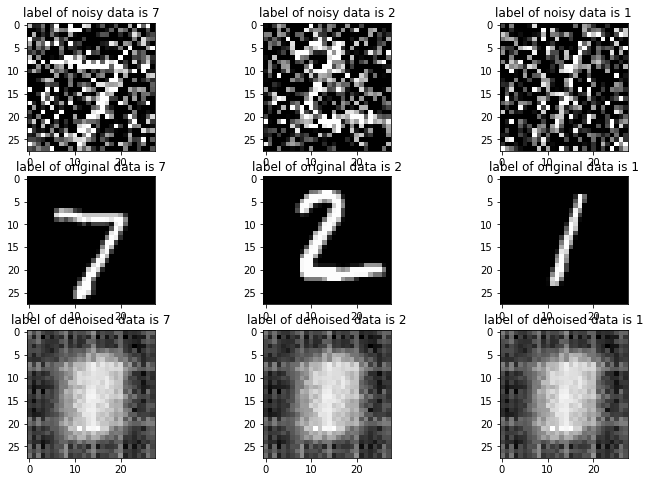

In [120]:
###########################   <YOUR CODE>  ############################
device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)

AE = our_VAE().to(device)
optimizer = optim.Adam(AE.parameters(), lr=1e-4)

# input = torch.ones(200,1,28,28).to(device)
# print(AE.encoder(input)[0].shape,AE.encoder(input)[1].shape,AE.encoder(input)[2].shape)

def train(epoch, device):

  AE.train() # we need to set the mode for our model

  for batch_idx, (item1,item2) in enumerate(train_loader): # Note that we do not need the labels
    image_batch1, _ = item1
    image_batch2, _ = item2

    optimizer.zero_grad()
    image_batch1 = image_batch1.to(device)
    image_batch2 = image_batch2.to(device)
    output, mu, log_var = AE(image_batch1)
    recon_loss, KL_loss = vae_loss(output, mu, log_var, image_batch1)

    loss = recon_loss + KL_loss # Here is a typical loss function (Mean square error)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append((recon_loss.item()/batch_size_train, KL_loss.item()/batch_size_train)) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*batch_size_train) + ((epoch-1)*len(train_loader.dataset)))
    if (batch_idx+1) % 300 == 0: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{(batch_idx+1)*len(image_batch1)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


def test(epoch, device):

  AE.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for item1,item2 in test_loader:
      image_batch1, _ = item1
      image_batch2, _ = item2
      image_batch1 = image_batch1.to(device)
      image_batch2 = image_batch2.to(device)
      output, mu, log_var = AE(image_batch1)
      recon_loss, KL_loss = vae_loss(output, mu, log_var, image_batch1)
      loss = recon_loss + KL_loss
      test_loss += loss.item()
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')
  return test_loss


train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 2

for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  test_loss = test(epoch, device=device)
  if test_loss < 20:
    break

AE.eval()

with torch.no_grad():
    for item1,item2 in test_loader:
      image_batch1, labels1 = item1
      image_batch2, labels2 = item2
      image_batch1 = image_batch1.to(device)
      image_batch2 = image_batch2.to(device)
      output, mu, log_var = AE(image_batch1)
      fig,ax = plt.subplots(3,3)
      fig.set_size_inches(12,8)
      for idx in range(3):
        ax[0,idx].imshow(image_batch1[idx][0].cpu().detach().numpy(), cmap='gray')
        ax[0,idx].set_title(f'label of noisy data is {labels1[idx]}')
        ax[1,idx].imshow(image_batch2[idx][0].cpu().detach().numpy(), cmap='gray')
        ax[1,idx].set_title(f'label of original data is {labels2[idx]}')
        ax[2,idx].imshow(output[idx][0].cpu().detach().numpy(), cmap='gray')
        ax[2,idx].set_title(f'label of denoised data is {labels1[idx]}')
      plt.show()
      break




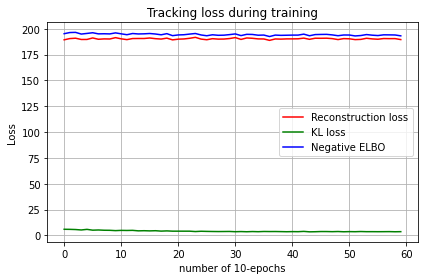

In [101]:
import matplotlib.pyplot as plt
train_losses = np.array(train_losses)
x_index = list(range(0,train_losses.shape[0],1))
plt.plot(x_index, train_losses[:,0], 'r', label='Reconstruction loss')
plt.plot(x_index, train_losses[:,1], 'g', label='KL loss')
plt.plot(x_index, train_losses[:,0]+train_losses[:,1], 'b', label='Negative ELBO')
plt.title("Tracking loss during training")     
plt.xlabel('number of 10-epochs')          
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
#########################  <END YOUR CODE>  ###########################

### Task 4.1: Latent space of VAE

The latent space will change over time during training as the networks learn which features of the input are most important.  In the beginning, the reconstruction error will be poor and the latent space will be mixed up (i.e., it has not identified good features for dimensionality reduction and then reconstruction).  However, as it continues to train, the space will begin to show some structure (similar to in PCA) as it finds features that enable good reconstruction even after adding a little noise. Therefore, to get some intuition about this process, in this task, you will visualize how latent space changes in the process of training with the given function ``plot_latent``.

1. For better visualization, create a VAE with ``latent_features=2``.
2. Similar to task 3, train the VAE for a few epochs. But you will need to plot the latent distribution using the provided ``plot_latent`` function below at initialization (so you can see what the latent space looks like at initialization) AND after **each** epoch. You should use the **test** data for plotting this visualization task.


In [107]:
def plot_latent(vae, data_loader, num_batches=2):
  with torch.no_grad():
    for ibx, (item1,_) in enumerate(data_loader):
      image_batch1, label1 = item1
      _,_,z = vae.encoder(image_batch1.to(device))
      z = z.to('cpu').detach().numpy()
      plt.scatter(z[:, 0], z[:, 1], c=label1, cmap='tab10',s=1)
      if ibx > num_batches:
        break
  plt.colorbar()
  plt.show()

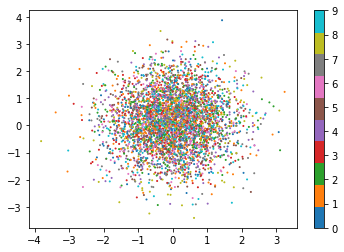

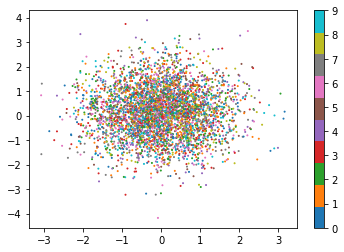

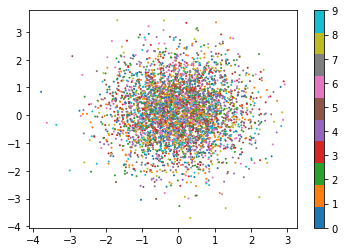

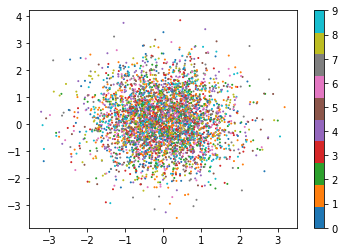

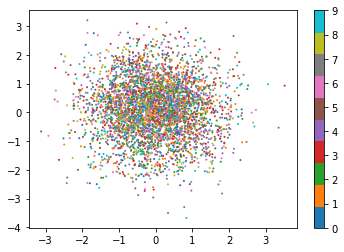

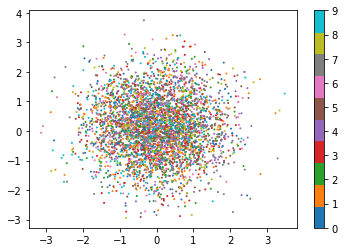

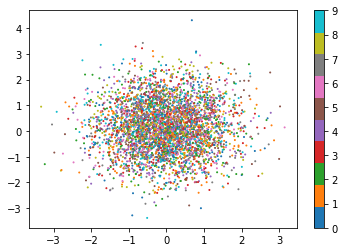

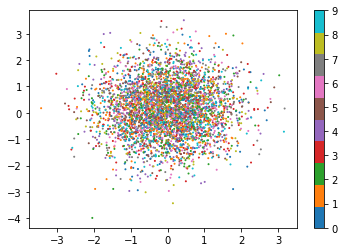

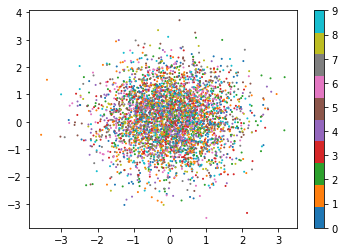

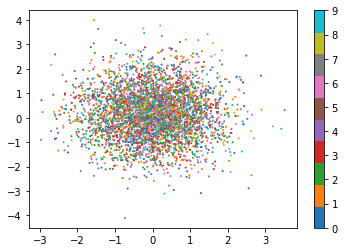

In [109]:
###########################   <YOUR CODE>  ############################
device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)

vae = our_VAE(2).to(device)
optimizer = optim.Adam(AE.parameters(), lr=1e-3)

# input = torch.ones(200,1,28,28).to(device)
# print(AE.encoder(input)[0].shape,AE.encoder(input)[1].shape,AE.encoder(input)[2].shape)

def train(epoch, device):

  vae.train() # we need to set the mode for our model

  for batch_idx, (item1,item2) in enumerate(train_loader): # Note that we do not need the labels
    image_batch1, _ = item1
    image_batch2, _ = item2

    optimizer.zero_grad()
    image_batch1 = image_batch1.to(device)
    image_batch2 = image_batch2.to(device)
    output, mu, log_var = vae(image_batch1)
    recon_loss, KL_loss = vae_loss(output, mu, log_var, image_batch1)

    loss = recon_loss + KL_loss # Here is a typical loss function (Mean square error)
    loss.backward()
    optimizer.step()
    
  vae.eval()
  plot_latent(vae, test_loader)
    
max_epoch = 10

for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
#########################  <END YOUR CODE>  ###########################

### Task 4.2 Interpolation of latent space

Interpolation can be quite useful for autoencoder models. For example, by linearly interpolating (or mixing) codes in latent space and decoding the result, the autoencoder can produce a more **semantically meaningful**
combination of the corresponding datapoints than linear interpolation in the raw pixel space. 
Besides, in some cases, interpolation experiments can show that the model has learned a latent space with a particular structure. Specifically, if interpolation between points in the latent space shows a smooth semantic warping in the original image space, then the visualization may suggest that similar points are semantically clustered in the latent space.

In this task, you will do a simple experiment to see the difference between linear interpolation in the latent space and the original data space (raw pixels).
1. With a trained model and test data, sample one $z\sim q(z|x)$ corresponding to label 0 and 1 separately (two samples in total); this can be done by passing test samples (with labels 0 and 1 respectively) through the encoder. These two latent samples will be denoted $z_0$ and $z_1$ respectively.

2. Compute the linear interpolation of $x_0$ and $x_1$ in the following way: $x'=\alpha x_1 + (1-\alpha)x_0$ where $\alpha = 0, 0.1, 0.2, \dots, 0.9, 1.0$. **Plot** all $x'$ images you get in a 1x11 grid.

3. Compute the latent linear interpolation of $z_0$ and $z_1$ to get $z'$ in a similar way. Then, reconstruct the $x'$ corresponding to each $z'$ using the decoder. **Plot** all $x'$ images you get in a 1x11 grid.

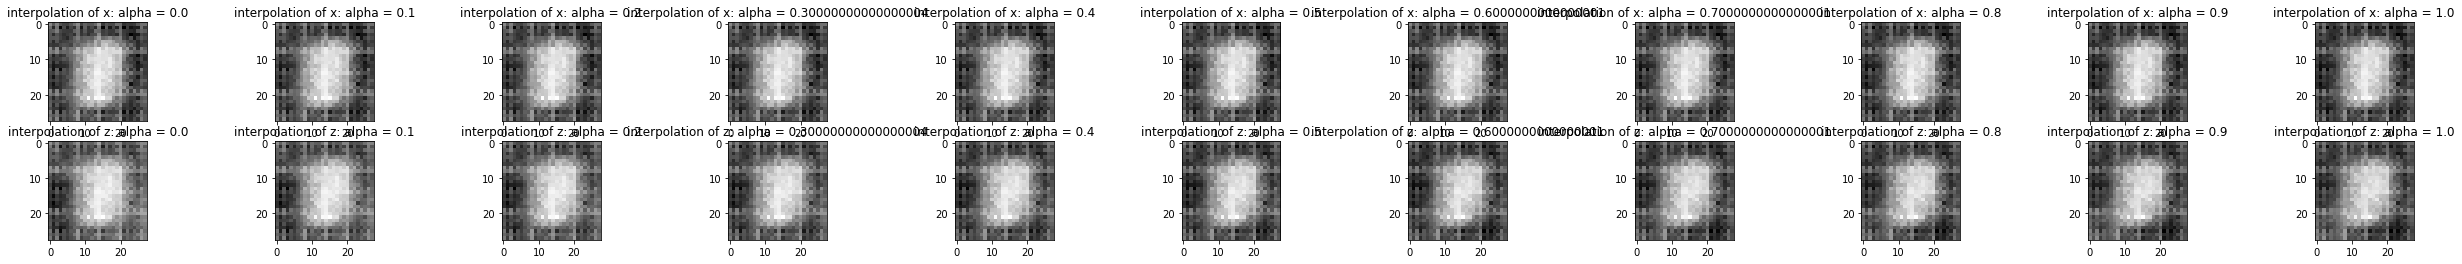

In [121]:
###########################   <YOUR CODE>  ############################
for batch_idx, (_,item2) in enumerate(test_loader): # Note that we do not need the labels
  image_batch2, label2 = item2
  sample1 = image_batch2[label2==0][:1]
  sample2 = image_batch2[label2==1][:1]
  AE.eval()
  with torch.no_grad():
    _,_,z1 = AE.encoder(sample1.to(device))
    _,_,z2 = AE.encoder(sample2.to(device))

  fig,ax = plt.subplots(2,11)
  fig.set_size_inches(44,4)
  for idx in range(0,11,1):
    interpolation1 = sample1*0.1*idx+(1-0.1*idx)*sample2
    interpolation2 = z1*0.1*idx+(1-0.1*idx)*z2
    interpolation1 = interpolation1.to(device)
    interpolation2 = interpolation2.to(device)
    output1,_,_ = AE(interpolation1)
    output2 = AE.decoder(interpolation2)
    ax[0,idx].imshow(output1[0,0].cpu().detach().numpy(), cmap='gray')
    ax[0,idx].set_title(f'interpolation of x: alpha = {idx*0.1}')
    ax[1,idx].imshow(output2[0,0].cpu().detach().numpy(), cmap='gray')
    ax[1,idx].set_title(f'interpolation of z: alpha = {idx*0.1}')
  plt.show()
  break
#########################  <END YOUR CODE>  ###########################